In [1]:
using Dierckx
using QuantEcon
using Plots
pyplot()
using Optim
using GLM
using JLD

INFO: Precompiling module Dierckx.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/QuantEcon.ji for module QuantEcon.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/FixedSizeArrays.ji for module FixedSizeArrays.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/RecipesBase.ji for module RecipesBase.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/PlotUtils.ji for module PlotUtils.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/PlotThemes.ji for module PlotThemes.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/Showoff.ji for module Showoff.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/john/.julia/lib/v0.5/Optim.ji for module Optim.
INFO: Precompiling module GLM.


# Model Setup

In [2]:

"""
Collection of transition matrix
"""
type TransitionMatrix
    P::Array{Float64,2}       # 4x4 
    Pz::Array{Float64,2}      # 2x2 aggregate shock
    Peps_gg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to good
    Peps_bb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to bad
    Peps_gb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to bad
    Peps_bg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to good
end

"""
Collection of model parameters
"""
immutable KSParameter
    u::Function
    beta::Float64
    alpha::Float64
    delta::Float64
    l_bar::Float64
    k_grid::Vector{Float64}
    K_grid::Vector{Float64}
    z_grid::Vector{Float64}
    eps_grid::Vector{Float64}
    s_grid::Array{Float64,2}
    k_size::Int64
    K_size::Int64
    z_size::Int64
    eps_size::Int64
    s_size::Int64
    ug::Float64
    ub::Float64
    TransMat::TransitionMatrix # bunch of transition matrix
    mu::Float64
end

""" 
Create transition matrices for aggregate shock,
idiosyncratic shock, and shock state

##### Arguments
- `ug` : unemployment rate in good state
- `ub` : unemployment rate in bad state
- `zg_ave_dur` : average duration of good state
- `zb_ave_dur` : average duration of bad state
- `ug_ave_dur` : average duration of unemployment in good state
- `ub_ave_dur` : average duration of unemployment in bad state
- `puu_rel_gb2bb` : prob. of u to u cond. on g to b relative to that of b to b 
- `puu_rel_bg2gg` : prob. of u to u cond. on b to g relative to that of g to g
"""
function create_transition_matrix(ug::Float64,ub::Float64,
        zg_ave_dur::Float64,zb_ave_dur::Float64,
        ug_ave_dur::Float64,ub_ave_dur::Float64,
        puu_rel_gb2bb::Float64,puu_rel_bg2gg::Float64)
    
    # probability of remaining in good state
    pgg = 1-1/zg_ave_dur
    # probability of remaining in bad state
    pbb = 1-1/zb_ave_dur
    # probability of changing from g to b
    pgb = 1-pgg
    # probability of changing from b to g
    pbg = 1-pbb  
    
    # prob. of 0 to 0 cond. on g to g
    p00_gg = 1-1/ug_ave_dur
    # prob. of 0 to 0 cond. on b to b
    p00_bb = 1-1/ub_ave_dur
    # prob. of 0 to 1 cond. on g to g
    p01_gg = 1-p00_gg
    # prob. of 0 to 1 cond. on b to b
    p01_bb = 1-p00_bb
    
    # prob. of 0 to 0 cond. on g to b
    p00_gb=puu_rel_gb2bb*p00_bb
    # prob. of 0 to 0 cond. on b to g
    p00_bg=puu_rel_bg2gg*p00_gg
    # prob. of 0 to 1 cond. on g to b
    p01_gb=1-p00_gb
    # prob. of 0 to 1 cond. on b to g
    p01_bg=1-p00_bg
    
    # prob. of 1 to 0 cond. on  g to g
    p10_gg=(ug - ug*p00_gg)/(1-ug)
    # prob. of 1 to 0 cond. on b to b
    p10_bb=(ub - ub*p00_bb)/(1-ub)
    # prob. of 1 to 0 cond. on g to b
    p10_gb=(ub - ug*p00_gb)/(1-ug)
    # prob. of 1 to 0 cond on b to g
    p10_bg=(ug - ub*p00_bg)/(1-ub)
    # prob. of 1 to 1 cond. on  g to g
    p11_gg= 1-p10_gg
    # prob. of 1 to 1 cond. on b to b
    p11_bb= 1-p10_bb
    # prob. of 1 to 1 cond. on g to b
    p11_gb= 1-p10_gb
    # prob. of 1 to 1 cond on b to g
    p11_bg= 1-p10_bg
    
    #   (g1)         (b1)        (g0)       (b0)
    P=[pgg*p11_gg pgb*p11_gb pgg*p10_gg pgb*p10_gb;
        pbg*p11_bg pbb*p11_bb pbg*p10_bg pbb*p10_bb;
        pgg*p01_gg pgb*p01_gb pgg*p00_gg pgb*p00_gb;
        pbg*p01_bg pbb*p01_bb pbg*p00_bg pbb*p00_bb
        ]
    Pz=[pgg pgb;
        pbg pbb]
    Peps_gg=[p11_gg p10_gg
              p01_gg p00_gg]
    Peps_bb=[p11_bb p10_bb
              p01_bb p00_bb]
    Peps_gb=[p11_gb p10_gb
              p01_gb p00_gb]
    Peps_bg=[p11_bg p10_bg
              p01_bg p00_bg]
    TransMat=TransitionMatrix(P,Pz,Peps_gg,Peps_bb,Peps_gb,Peps_bg)
    return TransMat
end

"""
Creates KSParameter instance
"""
function KSParameter(;
            beta::Float64=0.99,
            alpha::Float64=0.36,
            delta::Float64=0.025,
            k_min::Float64=1e-16,
            k_max::Float64=1000.0,
            k_size::Int64=100,
            K_min::Float64=20.0,
            K_max::Float64=50.0,
            K_size::Int64=4,
            z_min::Float64=0.99,
            z_max::Float64=1.01,
            z_size::Int64=2,
            eps_min::Float64=0.0,
            eps_max::Float64=1.0,
            eps_size::Int64=2,
            ug::Float64=0.04,
            ub::Float64=0.1,
            zg_ave_dur::Float64=8.0,
            zb_ave_dur::Float64=8.0,
            ug_ave_dur::Float64=1.5,
            ub_ave_dur::Float64=2.5,
            puu_rel_gb2bb::Float64=1.25,
            puu_rel_bg2gg::Float64=0.75,
            mu::Float64=0.0
            )
    u(c)=log(c)
    l_bar=1/(1-ub)
    k_grid=place_polynominal_grid(k_min,k_max,k_size,degree=0.7)   # individual capital grid
    K_grid=collect(linspace(K_min,K_max,K_size))   # aggregate capital grid
    z_grid=collect(linspace(z_max,z_min,z_size))   # aggregate technology shock
    eps_grid=collect(linspace(eps_max,eps_min,eps_size))  # idiosyncratic employment shock
    s_grid=gridmake(z_grid,eps_grid)               # shock grid
    # collection of transition matrices
    TransMat=create_transition_matrix(ug,ub,
        zg_ave_dur,zb_ave_dur,
        ug_ave_dur,ub_ave_dur,
        puu_rel_gb2bb,puu_rel_bg2gg)

    ksp=KSParameter(u,beta,alpha,delta,l_bar,k_grid,K_grid,z_grid,eps_grid,s_grid,
    k_size,K_size,z_size,eps_size,z_size*eps_size,ug,ub,TransMat,mu)

    return ksp
end

function place_polynominal_grid(k_min::Float64,k_max::Float64,k_size::Int64;degree::Float64=0.7)
    grid=Array{Float64}(k_size)
    grid[1]=k_min
    for i=2:k_size
        grid[i]=((i-1)/(k_size-1.0))^degree*(k_max-k_min)
    end
    return grid
end
"""
Compute interest rate given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
function fk(alpha,z,K,L)
    r=alpha*z*K^(alpha-1)*L^(1-alpha)
    return r
end

"""
Compute wage given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
function fl(alpha,z,K,L)
    r=(1-alpha)*z*K^(alpha)*L^(-alpha)
    return r
end

"""
Collection of KS solution
"""
type KSSolution
    k_opt::Array{Float64,3}
    value::Array{Float64,3}
    B::Vector{Float64}
end

"""
Create KSSolution instance
"""
function KSSolution(
        ksp::KSParameter;
        load_value::Bool=false,
        load_B::Bool=false)
    if load_value || load_B
        result=load("result.jld")
        kss_temp=result["kss"]
    end
    if load_value
        k_opt=kss_temp.k_opt
        value=kss_temp.value
    else
        k_opt=0.9*repeat(ksp.k_grid,outer=[1,ksp.K_size,ksp.s_size])
        value=ksp.u.(0.1/0.9*k_opt)/(1-ksp.beta)
    end
    if load_B
        B=kss_temp.B
    else
        B=[0.1, 0.95, 0.1, 0.95]
    end
    kss=KSSolution(k_opt,value,B)
    return kss
end


KSSolution

# Shock Generation

In [3]:

""" 
Translate shock index into shock value

##### Arguments
- `s_grid` : shock  grid
- `s_i` : shock index
"""
function get_shock(s_grid,s_i)
    return s_grid[s_i,1], s_grid[s_i,2] 
end


"""
Generate aggregate and idiosyncratic shock

##### Arguments
- `ksp` : instance of KSParameter type
- `z_shock_size` : size of aggregate shock
- `population` : size idiosyncratic shock in one period
"""
function generate_shocks(ksp::KSParameter;
        z_shock_size::Int64=11000,population::Int64=5000)
    # unpack parameters
    Peps_gg=ksp.TransMat.Peps_gg
    Peps_bg=ksp.TransMat.Peps_bg
    Peps_gb=ksp.TransMat.Peps_gb
    Peps_bb=ksp.TransMat.Peps_bb
    
    # draw aggregate shock
    z_shock=simulate(MarkovChain(ksp.TransMat.Pz,ksp.z_grid),z_shock_size)
    
    ### Let's draw individual shock ###
    eps_shock=Array{Float64}(z_shock_size,population) # preallocation
    
    # first period
    rand_draw=rand(population)
    if z_shock[1]==ksp.z_grid[1] # if good
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ug) # if draw is higher, become employed
    elseif z_shock[1]==ksp.z_grid[2] # if bad
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ub) # if draw is higher, become employed
    else
        error("the value of z_shock[1] (=$(z_shock[1])) is strange")
    end
    
    # from second period ...
    for t=2:z_shock_size
        if z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[1]  # if g to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gg)
        elseif z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[2]  # if b to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bg)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[1]  # if g to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gb)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[2]  # if b to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bb)
        else
            error("the value of z_shock[t] (=$(z_shock[t])) is strange")
        end
    end
    return z_shock, eps_shock
end

""" 
Draw idiosyncratic shock given previous idiosyncratic shock and 
transition matrix.
The transition matrix must be consistent with aggregate shock

##### Arguments
- `eps_shock` : preallocated vector. current period shock is stored in it
- `eps_shock_before` : previous period idiosyncratic shock
- `Peps` : transition matrix of the current period
"""
function draw_eps_shock(eps_shock_before::Vector{Float64},
                    Peps::Array{Float64,2})
    # preallocation
    eps_shocks=similar(eps_shock_before)
    
    # loop over entire population
    for i=1:length(eps_shocks)
        rand_draw=rand()
        if eps_shock_before[i]==1.0 # if employed now
            eps_shocks[i]=Float64(Peps[1,1]>rand_draw)
        elseif eps_shock_before[i]==0.0 # if unemployed now
            eps_shocks[i]=Float64(Peps[2,1]>rand_draw)
        else
            error("the value of eps_shock_before[i] (=$(eps_shock_before[i])) is strange at i=$i")
        end
    end
    return eps_shocks
end


draw_eps_shock

# Bellman equation and solve it

In [4]:

"""
Compute right hand side of bellman equation

##### Arguments
- `kp` : next period capital
- `ksm` : KSModel instance
- `k` : current individual capital
- `K` : current aggregate capital
- `L` : current labor
- `zeps_i` : 
"""
function rhs_bellman(ksp::KSParameter,
            kp::Float64,value::Array{Float64,3},
            k::Float64,K::Float64,s_i::Int64)
    u,s_grid,beta,alpha,l_bar,delta=ksp.u, ksp.s_grid, ksp.beta, ksp.alpha,ksp.l_bar,ksp.delta
    z, eps = get_shock(s_grid,s_i) 
    Kp,L=compute_Kp_L(K,s_i,kss.B,ksp) # Next period aggregate capital and current aggregate labor
    c=fk(alpha,z,K,L)*k+(1-delta)*k+fl(alpha,z,K,L)*(eps*l_bar+(1-eps)*ksp.mu)-kp # current consumption 
    expec=compute_expectation(kp,Kp,value,s_i,ksp)
    rhs=u(c)+beta*expec
    return rhs
end

"""
Compute expectation of next period value

##### Arguments
- `kp` : next period individual capital
- `Kp` : next period aggregate capital
- `value` : given value 
- `s_i` : current shock state
- `ksp` : KSParameter instance
"""
function compute_expectation(
              kp::Float64,  # next period indicidual capital
              Kp::Float64,  # next period aggragte capital
              value::Array{Float64,3}, # next period value
              s_i::Int64, # index of current state,
              ksp::KSParameter 
              )
    k_grid, K_grid = ksp.k_grid, ksp.K_grid # unpack grid
    beta, P = ksp.beta, ksp.TransMat.P      # unpack parameters
    
    # compute expectations by summing up
    expec=0.0
    for s_n_i=1:ksp.s_size
        value_itp=Spline2D(k_grid,K_grid,value[:,:,s_n_i],kx=3,ky=1)
        expec = expec + beta*P[s_i,s_n_i]*value_itp(kp,Kp)
    end
    return expec
end

"""
Compute next period aggregate capital and labor

##### Arguments
- `K` : Current aggregate capital
- `s_i` : current shock index
- `B` : coefficient of ALM for capital
"""
function compute_Kp_L(K::Float64,s_i::Int64,B::Vector{Float64},ksp::KSParameter)
    if ksp.s_grid[s_i,1]==ksp.z_grid[1]       # if aggregate shock is g
        Kp=exp(B[1]+B[2]*log(K))
        L=ksp.l_bar*(1-ksp.ug)
    elseif ksp.s_grid[s_i,1]==ksp.z_grid[2]   # if aggregate shock is b
        Kp=exp(B[3]+B[4]*log(K))
        L=ksp.l_bar*(1-ksp.ub)
    end
    return Kp, L
end

"""
Solve bellman equation for all states once

##### Arguments
- `k` : individual capital
- `K` : aggregate capital
- `s_i` : shock state index
- `ksp` : KSParameter
- `kss` : KSSolution
"""
function solve_bellman_once(
            k::Float64,
            K::Float64,
            s_i::Int64,
            ksp::KSParameter,
            kss::KSSolution,
            )
    # obtain minimum and maximum of grid
    k_min=minimum(ksp.k_grid)
    K_min=minimum(ksp.K_grid)
    K_max=maximum(ksp.K_grid)
    # unpack parameters
    alpha,delta,l_bar = ksp.alpha, ksp.delta, ksp.l_bar

    z, eps = get_shock(ksp.s_grid,s_i) # obtain shock value
    Kp,L=compute_Kp_L(K,s_i,kss.B,ksp) # next aggregate capital and current aggregate labor
    # restrict Kp within [K_min,K_max]
    Kp<K_min ? K_min:Kp 
    Kp>K_max ? K_max:Kp
    # if kp>k_c_pos, consumption is negative 
    k_c_pos=fk(alpha,z,K,L)*k+(1-delta)*k+fl(alpha,z,K,L)*(eps*l_bar+(1-eps)*ksp.mu)
    obj(kp)=-rhs_bellman(ksp,kp,kss.value,k,K,s_i) # objective function
    res=optimize(obj,0,k_c_pos) # maximize value
    # obtain result
    k_opt=Optim.minimizer(res) 
    value=-Optim.minimum(res)
    return k_opt, value
end

"""
Solve bellman equation for all states until convergence

##### Arguments
- `ksp` : KSParameter
- `kss` : KSSolution
- `tol` : tolerance of value function difference
- `max_iter` : maximum number of iteration
"""
function solve_bellman!(
            ksp::KSParameter,
            kss::KSSolution;
            tol::Float64=1e-8,
            max_iter::Int64=100,
            Howard::Bool=true,
            Howard_n_iter::Int64=20)
    counter_VFI=0  # counter
    while true
        counter_VFI=counter_VFI+1
        value_old=copy(kss.value) # guessed value
        # maximize value for all state
        solution = [solve_bellman_once(k,K,s_i,ksp,kss)
         for k in ksp.k_grid, K in ksp.K_grid, s_i in 1:ksp.s_size]
        # obtain results
        kss.k_opt.=
            reinterpret(Float64,solution,(2,ksp.k_size,ksp.K_size,ksp.s_size))[1,:,:,:]
        kss.value.=
            reinterpret(Float64,solution,(2,ksp.k_size,ksp.K_size,ksp.s_size))[2,:,:,:]
        # Howard's policy iteration
        if Howard 
            kss.value=iterate_policy(ksp,kss,n_iter=Howard_n_iter)
        end
        # difference of guessed and new value
        dif=maximum(abs(value_old-kss.value))
        println("VFI iteration $counter_VFI : dif = $dif")
        # if difference is sufficiently small
        if dif<tol
            println(" ** VFI converged successfully!!")
            break
        elseif counter_VFI >= max_iter
            println("VFI reached its maximum iteration : $max_iter")
            break
        end
    end
end

"""
Iterate the value function fixing the policy function

##### Arguments
- `ksp` : KSParameter instance
- `kss` : KSSolution instance
- `n_iter` : number of iterations
"""
function iterate_policy(ksp::KSParameter,
            kss::KSSolution;n_iter::Int64=20)
    value=copy(kss.value)
    for i=1:n_iter
        # old value
        value_old=copy(value)
        # update value using policy
        value .= 
            [rhs_bellman(ksp,
                kss.k_opt[k_i,K_i,s_i],value_old,
                ksp.k_grid[k_i],ksp.K_grid[K_i],s_i)
                for k_i in 1:ksp.k_size,
                    K_i in 1:ksp.K_size,
                    s_i in 1:ksp.s_size]
    end
    return value
end


iterate_policy

# Simulate path of aggregate capital

In [5]:

"""
Simulate aggregate capital's path using policy function 
and generated aggregate and idiosyncratic shock

##### Arguments
- `ksp` : KSParameter instance
- `z_shocks` : aggregate shocks
- `eps_shocks` : idiosyncratic shocks
- `k_population` : initial capital holding of all agents
"""
function simulate_aggregate_path(ksp::KSParameter,kss::KSSolution,
        z_shocks::Vector{Float64},eps_shocks::Array{Float64,2},
        k_population::Vector{Float64})
    
    println("simulating aggregate path ... please wait ... ")
    
    T=length(z_shocks)   # simulated duration
    N=size(eps_shocks,2) # number of agents
    
    K_ts=Array{Float64}(T) # preallocation of output (aggregate capital)
    
    # loop over T periods
    for (t,z) = enumerate(z_shocks)
        K_ts[t]=mean(k_population) # current aggrgate capital
        
        # s_i_base takes 1 when good and 2 when bad 
        s_i_base=1*(z==ksp.z_grid[1])+2*(z==ksp.z_grid[2])        
        
        # loop over individuals
        for (i,k) in enumerate(k_population)
            eps = eps_shocks[t,i]   # idiosyncratic shock
            s_i=s_i_base+2*(1-Int64(eps))  # transform (z,eps) to s_i
            # obtain next capital holding by interpolation
            itp_pol=Spline2D(ksp.k_grid,ksp.K_grid,kss.k_opt[:,:,s_i],kx=1,ky=1)
            k_population[i]=itp_pol(k,K_ts[t])
        end
    end
    
    return K_ts, k_population
end

"""
Simulate aggregate capital's pathusing policy function 
and generated aggregate and idiosyncratic shock
NOTE: initial capital holding is not required in this function

##### Arguments
- `ksp` : KSParameter instance
- `kss` : KSSolution instance
- `z_shocks` : aggregate shocks
- `eps_shocks` : idiosyncratic shocks
"""
function simulate_aggregate_path(ksp::KSParameter,kss::KSSolution,
        z_shocks::Vector{Float64},eps_shocks::Array{Float64,2})
    # allocate initial capital holdings
    k_population=ones(size(eps_shocks,2))
    
    # simulate using above function
    K_ts, k_population=simulate_aggregate_path(ksp,kss,
        z_shocks,eps_shocks,k_population)
    return K_ts, k_population
end

simulate_aggregate_path

# Obtaining aggregate law of motion coefficient

In [6]:

"""
Obtain new aggregate law of motion coefficients 
using the aggregate capital flaw

##### Arguments
- `ksp` : KSParameter instance
- `z_shock` : aggregate shocks
- `K_ts` : aggregate capital flaw
- `n_discard` : number of discarded samples
"""
function get_ALM_coefficient(ksp::KSParameter,
                             z_shock::Vector{Float64},K_ts::Vector{Float64};
                             n_discard::Int64=100)
    z_grid=ksp.z_grid
    n_g=count(i->(i==z_grid[1]),z_shocks[n_discard+1:1100-1])
    n_b=count(i->(i==z_grid[2]),z_shocks[n_discard+1:1100-1])
    B_n=Vector{Float64}(4)
    x_g=Vector{Float64}(n_g)
    y_g=Vector{Float64}(n_g)
    x_b=Vector{Float64}(n_b)
    y_b=Vector{Float64}(n_b)
    i_g=0
    i_b=0
    for t = n_discard+1:1100-1
        if z_shocks[t]==z_grid[1]
            i_g=i_g+1
            x_g[i_g]=log(K_ts[t])
            y_g[i_g]=log(K_ts[t+1])
        else
            i_b=i_b+1
            x_b[i_b]=log(K_ts[t])
            y_b[i_b]=log(K_ts[t+1])
        end
    end
    B_n[1],B_n[2]=linreg(x_g,y_g)
    B_n[3],B_n[4]=linreg(x_b,y_b)
    dif_B=maximum(abs(B_n-kss.B))
    println("difference of ALM coefficient is $dif_B")
    return B_n, dif_B
end

function find_ALM_coef!(
                       ksp::KSParameter,
                       kss::KSSolution,
                       z_shocks::Vector{Float64},
                       eps_shocks::Array{Float64,2};
                       tol_VFI::Float64=1e-8,
                       max_iter_VFI::Int64=100,
                       Howard_on::Bool=true,
                       Howard_n_iter::Int64=20,
                       tol_B::Float64=1e-8,
                       max_iter_B::Int64=20,
                       update_B::Float64=0.3,
                       T_discard::Int64=100)

    K_ts=similar(z_shocks)
    counter_B=0
    while true
        counter_B=counter_B+1
        println(" --- Iteration over ALM coefficient: $counter_B ---")

        # solve individual problem
        solve_bellman!(ksp,kss,
                       tol=tol_VFI,max_iter=max_iter_VFI,
                       Howard=Howard_on,Howard_n_iter=Howard_n_iter)

        # compute aggregate path of capital
        if counter_B != 1
            K_ts, k_population = simulate_aggregate_path(ksp,kss,z_shocks,eps_shocks,k_population)
        else
            K_ts, k_population = simulate_aggregate_path(ksp,kss,z_shocks,eps_shocks)
        end

        # obtain new ALM coefficient by regression
        B_n,dif_B = get_ALM_coefficient(ksp,z_shocks,K_ts,n_discard=T_discard)

        # check convergence
        if dif_B < tol_B
            println("-----------------------------------------------------")
            println("ALM coefficient successfully converged : dif = $dif_B")
            println("-----------------------------------------------------")
            break
        elseif counter_B == max_iter_B
            println("----------------------------------------------------------------")
            println("Iteration over ALM coefficient reached its maximum ($max_iter_B)")
            println("----------------------------------------------------------------")
            break
        end
        
        # Update B
        kss.B .= update_B .* B_n .+ (1-update_B) .* kss.B
    end
    return K_ts
end


find_ALM_coef! (generic function with 1 method)

# Plotting

In [7]:
"""
Plot actual and approximated ALM of capital 

##### Arguments
- `ksp.z_grid` : aggregate shock grid
- `z_shocks` : aggregate shock
- `kss.B` : ALM coefficient
- `K_ts` : actual path of capital
"""
function plot_ALM(z_grid::Vector{Float64},
                  z_shocks::Vector{Float64},
                  B::Vector{Float64},
                  K_ts::Vector{Float64})

    K_ts_approx = similar(K_ts) # preallocation

    # compute approximate ALM for capital
    K_ts_approx[1]=K_ts[1]

    for t=2:length(z_shocks)
        if z_shocks[t] == z_grid[1]
            K_ts_approx[t]=exp(B[1]+B[2]*log(K_ts_approx[t-1]))
        elseif z_shocks[t] == z_grid[2]
            K_ts_approx[t]=exp(B[3]+B[4]*log(K_ts_approx[t-1]))
        end
    end

    plot(1:length(K_ts),K_ts,lab="actual",color=:red,line=:solid)
    plot!(1:length(K_ts),K_ts_approx,lab="approximation",color=:blue,line=:dash)
    title!("aggregate law of motion for capital")
    
end

plot_ALM

# Implementation

In [8]:
# instance of KSParameter
ksp=KSParameter(k_size=30)
# instance of KSSolution
kss=KSSolution(ksp,load_value=false,load_B=false)

LoadError: File result.jld cannot be found

In [9]:
if size(kss.k_opt,1) != length(ksp.k_grid)
    error("loaded data is inconsistent with k_size")
end
if size(kss.k_opt,2) != length(ksp.K_grid)
    error("loaded data is inconsistent with K_size")
end

In [10]:
# generate shocks
z_shocks,eps_shocks =generate_shocks(ksp;
        z_shock_size=6000,population=3000)

([0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99  …  0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99],
[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 0.0])

In [11]:
# find ALM coefficient
@time K_ts = find_ALM_coef!(ksp,kss,z_shocks,eps_shocks,
               tol_VFI=1e-8,max_iter_VFI=50,Howard_on=true,Howard_n_iter=20,
               tol_B=1e-6, max_iter_B=50,update_B=0.3,
               T_discard=1000)

 --- Iteration over ALM coefficient: 1 ---
VFI iteration 1 : dif = 3274.3024566853182
VFI iteration 2 : dif = 853.5886590583559
VFI iteration 3 : dif = 187.09483171084375
VFI iteration 4 : dif = 71.72612338991271
VFI iteration 5 : dif = 47.344096765487365
VFI iteration 6 : dif = 30.799486499309666
VFI iteration 7 : dif = 20.117118615553792
VFI iteration 8 : dif = 13.331550284221152
VFI iteration 9 : dif = 8.84058125202749
VFI iteration 10 : dif = 5.838903749406214
VFI iteration 11 : dif = 3.8473466677599646
VFI iteration 12 : dif = 2.535338346457266
VFI iteration 13 : dif = 1.6715138240675884
VFI iteration 14 : dif = 1.1018614541118552
VFI iteration 15 : dif = 0.7257371607888814
VFI iteration 16 : dif = 0.47757937111597926
VFI iteration 17 : dif = 0.31419755649177716
VFI iteration 18 : dif = 0.20679113959538142
VFI iteration 19 : dif = 0.1361329963276745
VFI iteration 20 : dif = 0.08960264937222462
VFI iteration 21 : dif = 0.05895237541793108
VFI iteration 22 : dif = 0.0387747095733601

6000-element Array{Float64,1}:
 98.5115
 98.449 
 98.3789
 98.33  
 98.2829
 98.219 
 98.1576
 98.1223
 98.0912
 98.0639
 98.0342
 97.9945
 97.9542
  ⋮     
 99.1945
 99.1266
 99.0531
 98.9757
 98.9073
 98.8315
 98.7801
 98.7359
 98.7003
 98.6665
 98.6372
 98.578 


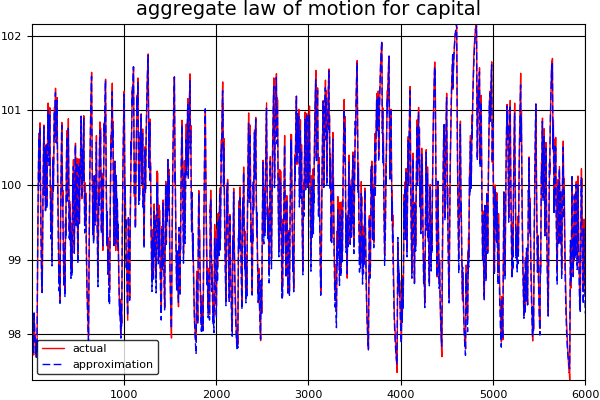

In [12]:
plot_ALM(ksp.z_grid,z_shocks,
         kss.B,K_ts)

In [13]:
kss.B  # Regression coefficient

4-element Array{Float64,1}:
 0.23048 
 0.950196
 0.235072
 0.948665

In [14]:
save("result.jld","kss",kss,"K_ts",K_ts)